In [5]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

sys.path.append("..")

In [11]:
import sh_utilities
import utilities
from pathlib import Path
import imageio.v3 as im
import cv2
import matplotlib.pyplot as plt
import spherical_harmonics as sh

Reading image...
Running spherical harmonics...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.9559894..44.078556].


1.0
0.9999600015999359
0.9996401295533609
0.9985620706183095
0.9960159362549801
0.9910802775024778
0.9826657757163633
0.9695935463853552
0.9507149376331


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.703876..43.27069].


1.0
0.9996001599360256
0.9964129135113591
0.9858044164037855
0.9615384615384615
0.9174311926605504
0.8500510030601836
0.761266747868453
0.6585879873551106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9683087..37.28131].


1.0
0.9960159362549801
0.9652509652509652
0.8741258741258741
0.7142857142857143
0.5263157894736842
0.361794500723589
0.24177949709864602
0.1617076326002587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20411412..20.917202].


1.0
0.9615384615384615
0.7352941176470589
0.4098360655737705
0.2
0.1
0.0536480686695279
0.030902348578491966
0.018925056775170326


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20186728..8.477744].


1.0
0.7142857142857143
0.21739130434782605
0.06493506493506493
0.024390243902439025
0.01098901098901099
0.005636978579481397
0.0031786395422759056
0.0019252984212552947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07739729..3.3696709].


1.0
0.3333333333333333
0.05263157894736842
0.0136986301369863
0.004975124378109453
0.0022172949002217295
0.0011325028312570782
0.0006373486297004461
0.0003856536829926726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.43565375..1.6784056].


1.0
0.2
0.02702702702702703
0.006896551724137931
0.0024937655860349127
0.0011098779134295228
0.0005665722379603399
0.000318775900541919
0.00019286403085824494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.60801065..1.2210429].


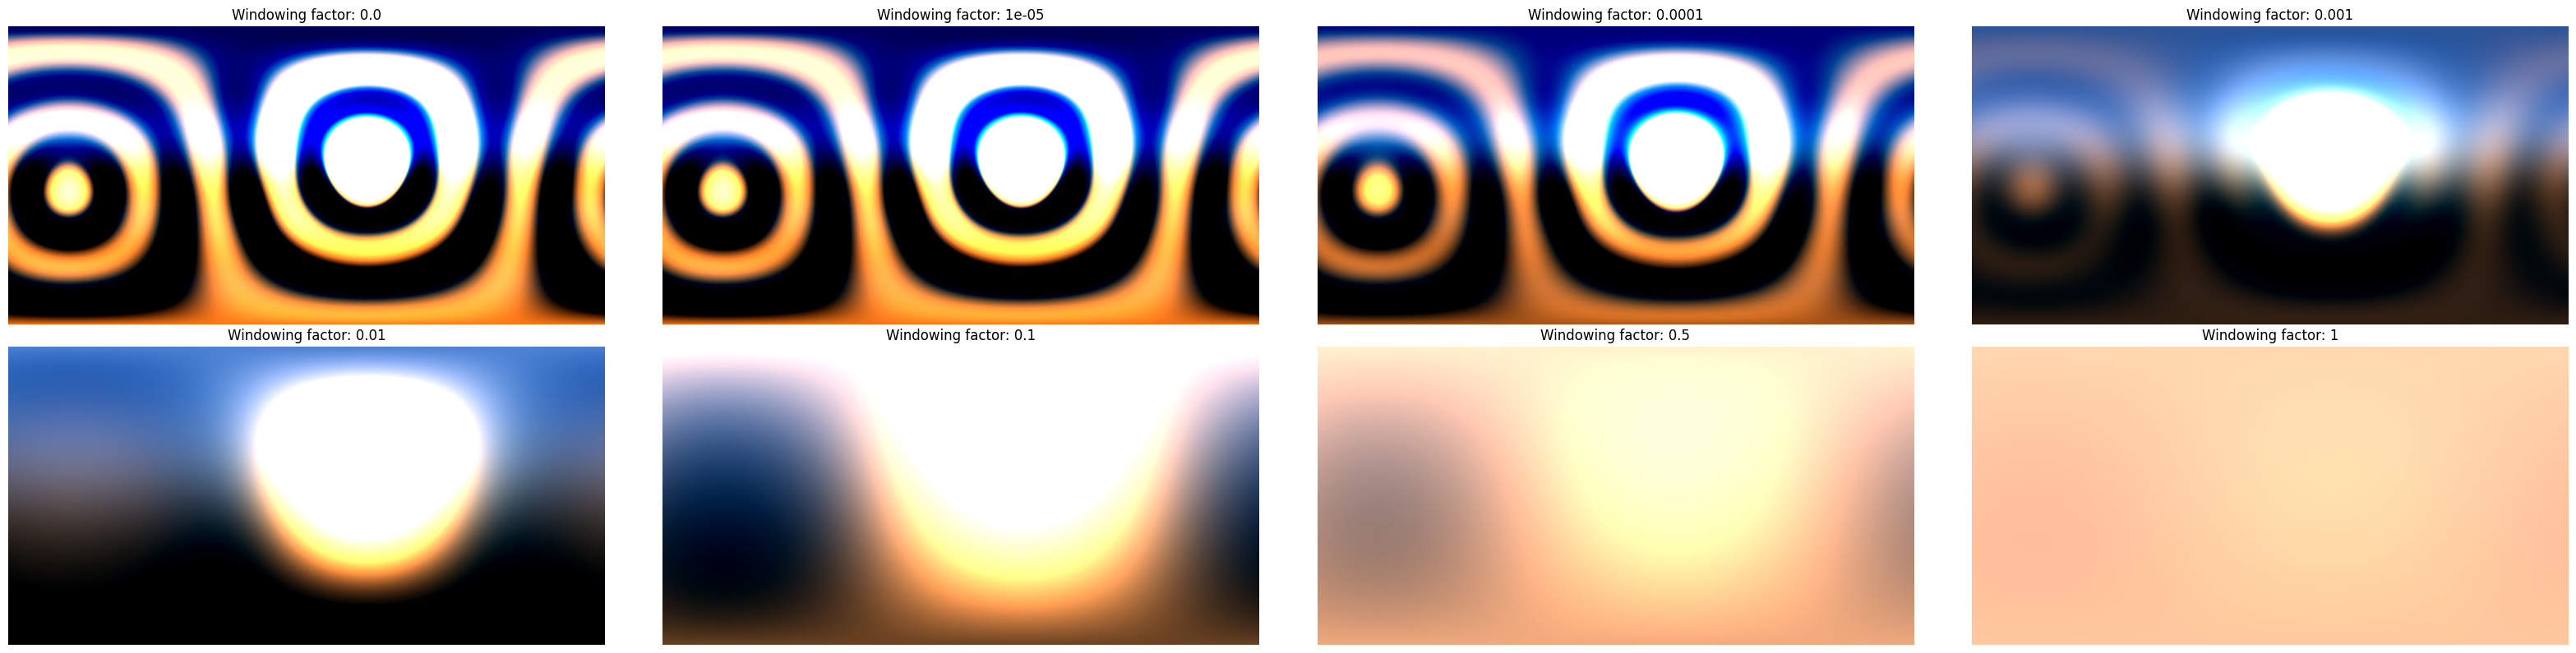

In [14]:
l_max = 8
width = 1000
apply_window = 0.0

window_values = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1]

filename = "../images/small_harbour_sunset_4k.hdr"

print("Reading image...")
plugin = "EXR-FI" if Path(filename).suffix == ".exr" else "HDR-FI"
height = width // 2
radiance_map_data = utilities.resize_image(
    im.imread(filename, plugin=plugin)[:, :, :3],
    width,
    height,
    cv2.INTER_CUBIC,
)


def apply_windowing(coeffs, windowing_factor=None, verbose=False):
    # http://www.ppsloan.org/publications/StupidSH36.pdf
    l_max = sh_utilities.sh_l_max_from_terms(coeffs.shape[0])
    if windowing_factor <= 0:
        if verbose:
            print("No windowing applied")
        return coeffs
    if verbose:
        print("Using windowing_factor: %s" % (windowing_factor))
    for l_sh in range(0, l_max + 1):
        s = 1.0 / (
            1.0 + windowing_factor * l_sh * l_sh * (l_sh + 1.0) * (l_sh + 1.0)
        )
        for m in range(-l_sh, l_sh + 1):
            coeffs[sh.sh_index(l_sh, m), :] *= s
        print(s)
    return coeffs


# SPH projection
print("Running spherical harmonics...")
# ibl_coeffs = sh_utilities.get_coefficients_from_file(args.ibl_filename, args.l_max, resize_width=args.resize_width)
ibl_coeffs_original = sh_utilities.get_coefficients_from_image(
    radiance_map_data, l_max, resize_width=width
)


cols = 4
rows = len(window_values) // cols + (len(window_values) % cols > 0)
fig, ax = plt.subplots(rows, cols, figsize=(4 * cols * 2, 4 * rows))
windowed_coeffs = []

Path("./output_windows").mkdir(exist_ok=True)
for i, windowing_factor in enumerate(window_values):
    ibl_coeffs = apply_windowing(
        ibl_coeffs_original, windowing_factor=windowing_factor
    )
    windowed_coeffs.append(ibl_coeffs)
    reconstructed_signal = sh_utilities.sh_reconstruct_signal(
        ibl_coeffs, width=width
    )
    ax[i // cols, i % cols].imshow(reconstructed_signal)
    ax[i // cols, i % cols].set_title(f"Windowing factor: {windowing_factor}")
    ax[i // cols, i % cols].axis("off")
    im.imwrite(
        f"output_windows/sh_light_l{l_max}_{windowing_factor}.exr",
        reconstructed_signal,
    )

fig.tight_layout()
plt.show()

In [4]:
import numpy as np
import scipy.signal
import scipy.special


def design_lowpass_filter(numtaps, cutoff, width, fs, radial=False):
    assert numtaps >= 1

    # Identity filter.
    if numtaps == 1:
        return None

    # Separable Kaiser low-pass filter.
    if not radial:
        f = scipy.signal.firwin(
            numtaps=numtaps, cutoff=cutoff, width=width, fs=fs
        )
        return f

    # Radially symmetric jinc-based filter.
    x = (np.arange(numtaps) - (numtaps - 1) / 2) / fs
    r = np.hypot(*np.meshgrid(x, x))
    f = scipy.special.j1(2 * cutoff * (np.pi * r)) / (np.pi * r)
    beta = scipy.signal.kaiser_beta(
        scipy.signal.kaiser_atten(numtaps, width / (fs / 2))
    )
    w = np.kaiser(numtaps, beta)
    f *= np.outer(w, w)
    f /= np.sum(f)
    return f

In [12]:
def kaiser_apply_windowing(coeffs, windowing_factor=None, verbose=False):
    # http://www.ppsloan.org/publications/StupidSH36.pdf
    l_max = sh_utilities.sh_l_max_from_terms(coeffs.shape[0])
    for l_sh in range(0, l_max + 1):
        s = 1.0 / (
            1.0 + windowing_factor * l_sh * l_sh * (l_sh + 1.0) * (l_sh + 1.0)
        )
        for m in range(-l_sh, l_sh + 1):
            coeffs[sh.sh_index(l_sh, m), :] *= s
    return coeffs

In [9]:
filter = design_lowpass_filter(
    numtaps=4,
    cutoff=16,
    width=radiance_map_data.shape[1],
    fs=512,
)

In [10]:
filter

array([0.00061953, 0.49938047, 0.49938047, 0.00061953])